In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import wfdb

from collections import Counter

## check annotation type and number of one record

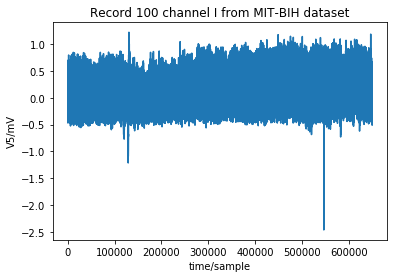

In [2]:
# read a wfdb record and plot the signal
record = wfdb.rdrecord('100', sampfrom=0, sampto='end', channels=[1], pb_dir='mitdb')
wfdb.plot_wfdb(record=record, title='Record 100 channel I from MIT-BIH dataset')

In [3]:
# rdsamp function reads in certain channels and sections of the WFDB record
# and returns a numpy array and a dictionary
signals, fields = wfdb.rdsamp('100', sampfrom=0, sampto='end', channels=[1], pb_dir='mitdb')
display(signals)
display(fields)

array([[-0.065],
       [-0.065],
       [-0.065],
       ..., 
       [-0.365],
       [-0.335],
       [ 0.   ]])

{'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'fs': 360,
 'sig_name': ['V5'],
 'units': ['mV']}

In [4]:
# check data shape
signals.shape

(650000, 1)

In [5]:
# check data type
signals.dtype

dtype('float64')

In [15]:
# Read a WFDB annotation file into a wfdb.Annotation object, and plot the samples
annotation = wfdb.rdann('100', 'atr', sampfrom=0, sampto=None, shift_samps=True, pb_dir='mitdb')
annotation.fs = 360

In [16]:
# "sample" method returns a numpy array containing the annotation locations in samples
# relative to the beginning of the record
annotation.sample

array([    18,     77,    370, ..., 649484, 649734, 649991])

In [17]:
# check data shape
annotation.sample.shape

(2274,)

In [18]:
# check list length
len(annotation.symbol)

2274

In [19]:
# unique symbols in the symbol list
# + means Rhythm change
# 'A' means Atrial premature beat
# 'N' means Normal beat
# 'V' means Premature ventricular contraction

Counter(annotation.symbol).keys()

dict_keys(['+', 'N', 'A', 'V'])

In [20]:
# how many of each symbol in the list
# there are 2239 normal beats, 33 atrial premature beats and 1 PVC beat
# in the "100" record of MIT-BIH database

Counter(annotation.symbol).values()

dict_values([1, 2239, 33, 1])

In [22]:
# get the location of the PVC beat
annotation.symbol.index('V')

1907

In [24]:
# get the time-stamp of the PVC beat
annotation.sample[1907]

546792

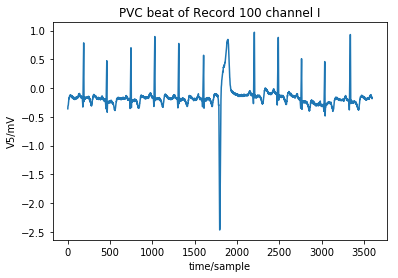

In [25]:
# get 10-second window of the PVC beat (5 seconds before and after)
pvc_record = wfdb.rdrecord('100', sampfrom=(546792-360*5), sampto=(546792+360*5), channels=[1], pb_dir='mitdb')
wfdb.plot_wfdb(record=pvc_record, title='PVC beat of Record 100 channel I')

## check annotation type and number of all records

In [2]:
# check every MIT-BIH data record to identify the type and number of annotations
# get all the record names in a list
namelist = []
namelist = namelist + list(range(100,125,1)) + list(range(200,235,1))
for num in [110,120,204,206,211,216,218,224,225,226,227,229]:
    namelist.remove(num)

len(namelist)

48

In [13]:
# check all records
for record in namelist:
    annotation = wfdb.rdann(str(record), 'atr', sampfrom=0, sampto=None, shift_samps=True, pb_dir='mitdb')
    print('Record', record, Counter(annotation.symbol))
    

Record 100 Counter({'N': 2239, 'A': 33, '+': 1, 'V': 1})
Record 101 Counter({'N': 1860, '~': 4, '|': 4, 'A': 3, 'Q': 2, '+': 1})
Record 102 Counter({'/': 2028, 'N': 99, 'f': 56, '+': 5, 'V': 4})
Record 103 Counter({'N': 2082, '~': 6, 'A': 2, '+': 1})
Record 104 Counter({'/': 1380, 'f': 666, 'N': 163, '+': 45, '~': 37, 'Q': 18, 'V': 2})
Record 105 Counter({'N': 2526, '~': 88, 'V': 41, '|': 30, 'Q': 5, '+': 1})
Record 106 Counter({'N': 1507, 'V': 520, '+': 41, '~': 30})
Record 107 Counter({'/': 2078, 'V': 59, '~': 2, '+': 1})
Record 108 Counter({'N': 1739, '~': 41, 'V': 17, 'x': 11, '|': 8, 'A': 4, 'F': 2, '+': 1, 'j': 1})
Record 109 Counter({'L': 2492, 'V': 38, 'F': 2, '~': 2, '+': 1})
Record 111 Counter({'L': 2123, '~': 8, '+': 1, 'V': 1})
Record 112 Counter({'N': 2537, '~': 10, 'A': 2, '+': 1})
Record 113 Counter({'N': 1789, 'a': 6, '+': 1})
Record 114 Counter({'N': 1820, 'V': 43, 'A': 10, '~': 7, 'F': 4, '+': 3, 'J': 2, '|': 1})
Record 115 Counter({'N': 1953, '|': 6, '~': 2, '+': 1})

## slice 10-seconds window for every records

In [3]:
# define a function that takes in record signal and annotation
# and returns 10-seconds window signal value list and 1-or-0 annotation list

def get_window (signals, annotation):
    """
    this function gives a 10-seconds window (5s before, 5s after the annotation mark)
    of the ECG signals and assign value 1 if it's PVC beat and 0 otherwise
    parameter: signals: numpy array containing heart beat record values
               annotation: wfdb.annotation object containing heart beat annotations
    return: two lists
            siglist: a list of lists of length 3600 
            annlist: a list containing 1 if PVC beat, 0 otherwise
    """
    siglist = []
    annlist = []
    
    #loop through the annotation.symbol list
    for i in range(len(annotation.symbol)):
        timestamp = annotation.sample[i] #get the timestamp
        
        #test if that timestamp can have 5 seconds before and after window
        windowStart = timestamp - 5*annotation.fs
        windowEnd = timestamp + 5*annotation.fs
        if windowStart >= 0 & windowEnd <= len(signals):
            if annotation.symbol[i] == 'V':
                # check if the length of this strip is 3600
                if len(signals[windowStart:windowEnd,].flatten().tolist()) == 10*annotation.fs:
                    siglist.append(signals[windowStart:windowEnd,].flatten().tolist())
                    annlist.append(1)
                else:
                    continue
            else:
                # check if the length of this strip is 3600
                if len(signals[windowStart:windowEnd,].flatten().tolist()) == 10*annotation.fs:
                    siglist.append(signals[windowStart:windowEnd,].flatten().tolist())
                    annlist.append(0)
        else:
            continue
    
    return siglist, annlist
    

In [4]:
# loop through all record to get all the 10-seconds window signal list and annotation list
# this could be the training dataset for the neural network model
# this takes several minutes to run

ECG_signals = []
PVC_annotations = []

for record in namelist:
    signals, fields = wfdb.rdsamp(str(record), sampfrom=0, sampto='end', channels=[1], pb_dir='mitdb')
    annotation = wfdb.rdann(str(record), 'atr', sampfrom=0, sampto=None, shift_samps=True, pb_dir='mitdb')
    
    signal_list, annotation_list = get_window(signals, annotation)
    
    ECG_signals = ECG_signals + signal_list
    PVC_annotations = PVC_annotations + annotation_list
    
    print('record', record, 'is done.')

record 100 is done.
record 101 is done.
record 102 is done.
record 103 is done.
record 104 is done.
record 105 is done.
record 106 is done.
record 107 is done.
record 108 is done.
record 109 is done.
record 111 is done.
record 112 is done.
record 113 is done.
record 114 is done.
record 115 is done.
record 116 is done.
record 117 is done.
record 118 is done.
record 119 is done.
record 121 is done.
record 122 is done.
record 123 is done.
record 124 is done.
record 200 is done.
record 201 is done.
record 202 is done.
record 203 is done.
record 205 is done.
record 207 is done.
record 208 is done.
record 209 is done.
record 210 is done.
record 212 is done.
record 213 is done.
record 214 is done.
record 215 is done.
record 217 is done.
record 219 is done.
record 220 is done.
record 221 is done.
record 222 is done.
record 223 is done.
record 228 is done.
record 230 is done.
record 231 is done.
record 232 is done.
record 233 is done.
record 234 is done.


In [5]:
len(ECG_signals)

111985

In [6]:
len(PVC_annotations)

111985

In [7]:
# there are 7112 PVC 10-seconds window, 105186 non-PVC 10-seconds window
Counter(PVC_annotations)

Counter({0: 104886, 1: 7099})

In [59]:
# write ECG signals data to csv file
# this takes several minutes to run
# the resulting csv file is about 2.2GB, DON'T push that to GitHub

import csv

with open('MIT-BIH.csv', 'w') as f:
    f_csv = csv.writer(f)
    f_csv.writerows(ECG_signals)

In [60]:
# write the PVC annotation data to csv file

with open('MIT-BIH-Annotation.csv', 'w') as f:
    f_csv = csv.writer(f)
    f_csv.writerow(PVC_annotations)

## plot of PVC and normal beat

In [66]:
# read in records
signals, fields = wfdb.rdsamp('114', sampfrom=0, sampto='end', channels=[1], pb_dir='mitdb')
annotation = wfdb.rdann('114', 'atr', sampfrom=0, sampto=None, shift_samps=True, pb_dir='mitdb')
    
signal_list, annotation_list = get_window(signals, annotation)

In [63]:
# get PVC beats index
pvc_index = []
for i in range(len(annotation_list)):
    if annotation_list[i] == 1:
        pvc_index.append(i)
pvc_index

[1900]

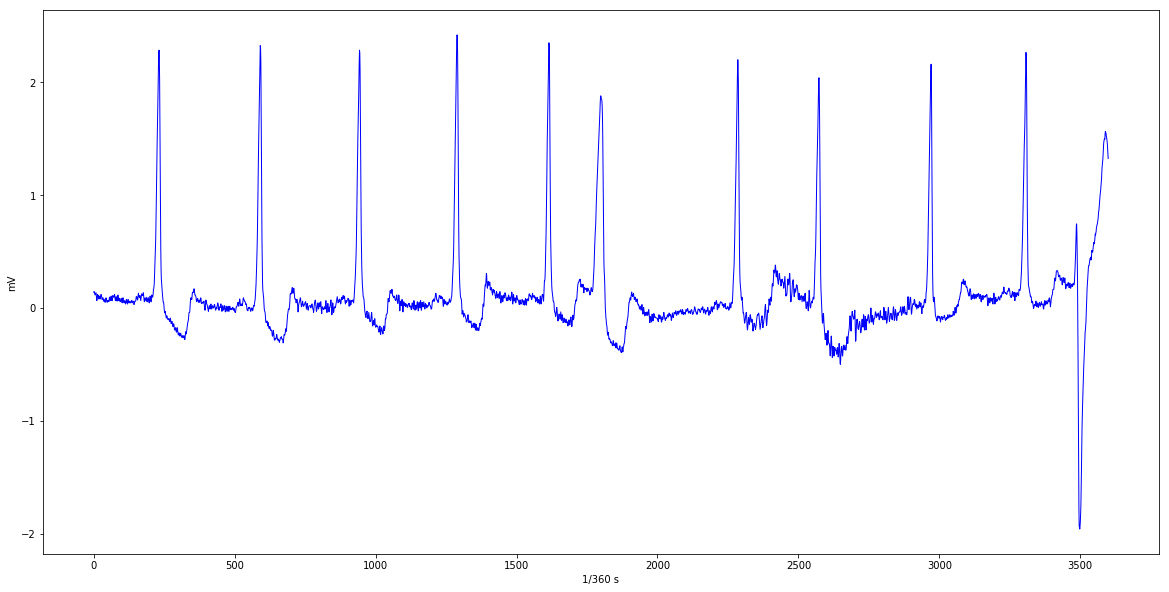

In [75]:
plt.figure(figsize=(20,10))
plt.plot(signal_list[952], 'b-', linewidth=1)
plt.xlabel('1/360 s')
plt.ylabel('mV')
plt.show()

## classification model

In [8]:
# transform data into numpy array

X = np.array(ECG_signals)
y = np.array(PVC_annotations)

In [9]:
X.shape

(111985, 3600)

In [10]:
y.shape

(111985,)

In [11]:
# stratified sampling

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [12]:
for train_index, test_index in split.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

In [13]:
X_train.shape

(89588, 3600)

In [14]:
y_train.shape

(89588,)

In [15]:
X_test.shape

(22397, 3600)

In [16]:
y_test.shape

(22397,)

In [17]:
# the ratio of PVC beats in training set and test set
# should be about the same

Counter(y_train)

Counter({0: 83909, 1: 5679})

In [18]:
5679/(5679+83909)

0.06339018618564986

In [19]:
Counter(y_test)

Counter({0: 20977, 1: 1420})

In [20]:
1420/(1420+20977)

0.06340134839487431

### SGD Classifier

In [36]:
from sklearn.linear_model import SGDClassifier

In [37]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

C:\Users\movin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [38]:
from sklearn.model_selection import cross_val_score

In [39]:
# evaluate performance using accuracy score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

C:\Users\movin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\movin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\movin\Anaconda3\lib\sit

array([ 0.93600777,  0.93085089,  0.92843748])

In [41]:
# baseline model: predict every observation to be 0

83909/(5679+83909)

0.9366098138143502

In [42]:
# evaluate performance using confusion matrix

from sklearn.model_selection import cross_val_predict

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

C:\Users\movin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\movin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\movin\Anaconda3\lib\sit

In [24]:
from sklearn.metrics import confusion_matrix

In [44]:
confusion_matrix(y_train, y_train_pred)

array([[81867,  2042],
       [ 4071,  1608]], dtype=int64)

In [45]:
# accuracy
(81867+1608)/(81867+1608+2042+4071)

0.931765415010939

In [46]:
# True Positive Rate
1608/(1608+4071)

0.283148441627047

In [47]:
# False Positive Rate
2042/(2042+81867)

0.024335887687852317

### Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
# Caution: this can take 30 minutes to run

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
y_train_pred = log_reg.predict(X_train)

In [51]:
confusion_matrix(y_train, y_train_pred)

array([[83526,   383],
       [ 4004,  1675]], dtype=int64)

In [52]:
# training accuracy
(83526+1675)/(83526+1675+383+4004)

0.9510313881323391

In [54]:
# True Positive Rate
1675/(1675+4004)

0.2949462933615073

In [55]:
# False Positive Rate
383/(383+83526)

0.004564468650561918

In [56]:
# testing result
y_test_pred = log_reg.predict(X_test)
confusion_matrix(y_test, y_test_pred)

array([[20860,   117],
       [ 1065,   355]], dtype=int64)

In [57]:
# testing accuracy 0.9472 less than training accuracy 0.9510
# but better than baseline model accuracy 0.9366

(20860+355)/(20860+355+117+1065)

0.9472250747868018

In [58]:
# True Positive Rate
355/(355+1065)

0.25

In [60]:
# False Positive Rate
117/(117+20860)

0.0055775373027601655

In [63]:
log_reg.get_params(deep=True)

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Random Forest

In [21]:
from sklearn.ensemble import RandomForestRegressor

In [22]:
# Caution: this can take several hours to run

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [25]:
y_train_pred = forest_reg.predict(X_train)
y_train_pred = [int(x) for x in y_train_pred]
confusion_matrix(y_train, y_train_pred)

array([[83909,     0],
       [ 2483,  3196]], dtype=int64)

In [26]:
# training accuracy
(3196+83909)/(3196+83909+2483+0)

0.9722842344956913

In [27]:
# true positive rate
3196/(3196+2483)

0.562775136467688

In [28]:
# false positive rate
0/83909

0.0

In [29]:
y_test_pred = forest_reg.predict(X_test)
y_test_pred = [int(x) for x in y_test_pred]
confusion_matrix(y_test, y_test_pred)

array([[20975,     2],
       [  816,   604]], dtype=int64)

In [30]:
# testing accuracy
(604+20975)/(604+20975+2+816)

0.9634772514176005

In [31]:
# true positive rate
604/(604+816)

0.4253521126760563

In [32]:
# false positive rate
2/(2+20975)

9.534251799590027e-05

In [34]:
forest_reg.get_params(deep=True)

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [35]:
# save the model

import pickle

# Dump the trained random forest classifier with Pickle
RandomForest_pkl_filename = 'RandomForest_10s.pkl'

# Open the file to save as pkl file
RandomForest_model_pkl = open(RandomForest_pkl_filename, 'wb')
pickle.dump(forest_reg, RandomForest_model_pkl)

# Close the pickle instances
RandomForest_model_pkl.close()

### Classical Claasifier Results

|model|accuracy|true positive rate|false positive rate|
|-----|--------|------------------|-------------------|
|baseline|0.9366|0.0|0.0|
|Logistic Regression training|0.9510|0.2949|0.0046|
|Logistic Regression testing|0.9472|0.2500|0.0056|
|Random Forest training|0.9723|0.5628|0.0|
|Random Forest testing|0.9635|0.4254|0.0001|